The files in this folder have been taken from the [examples folder](https://github.com/atztogo/phonopy/tree/master/example/NaCl) of the [phonopy repo](https://github.com/atztogo/phonopy). The reason I chose this example is because it's used in some of the [documentation](https://atztogo.github.io/phonopy/phonopy-module.html).

I found a old [presentation about phonopy](http://icms3.weebly.com/uploads/3/5/9/0/3590130/version1.pdf) that I think might help us understand some of the terminology.

I also found an old [PDF manual for Phonopy](https://www.researchgate.net/profile/Fatih_Ersan/post/How_can_I_calculate_lattice_thermal_conductivity_using_phonopy_code/attachment/59d6262579197b80779846ef/AS:320708796715008@1453474343187/download/phonopy-manual.pdf) that might also be useful.

This notebooks takes `NaCl.py`, splits it into sensible cells and suprpesses some of the text output.

There is a lot of discussion about VASP - I think we will need to learn what it does and how to use it.

In [1]:
%matplotlib inline
import numpy as np
from phonopy import Phonopy
from phonopy.interface.vasp import read_vasp
from phonopy.file_IO import parse_FORCE_SETS, parse_BORN
from phonopy.structure.atoms import PhonopyAtoms

In [2]:
def append_band(bands, q_start, q_end):
    band = []
    for i in range(51):
        band.append(np.array(q_start) +
                    (np.array(q_end) - np.array(q_start)) / 50 * i)
    bands.append(band)

In [3]:
# NaCl crystal structure is read from POSCAR.
unitcell = read_vasp("POSCAR")
# This can be given via a PhonopyAtoms class as follows:
# unitcell = PhonopyAtoms(symbols=(['Na'] * 4 + ['Cl'] * 4),
#                         cell=(np.eye(3) * 5.6903014761756712),
#                         scaled_positions=[[0, 0, 0],
#                                           [0, 0.5, 0.5],
#                                           [0.5, 0, 0.5],
#                                           [0.5, 0.5, 0],
#                                           [0.5, 0.5, 0.5],
#                                           [0.5, 0, 0],
#                                           [0, 0.5, 0],
#                                           [0, 0, 0.5]])

In [4]:
phonon = Phonopy(unitcell,
                 [[2, 0, 0],
                  [0, 2, 0],
                  [0, 0, 2]],
                 primitive_matrix=[[0, 0.5, 0.5],
                                   [0.5, 0, 0.5],
                                   [0.5, 0.5, 0]])

In [5]:
symmetry = phonon.get_symmetry()
print("Space group: %s" % symmetry.get_international_table())

Space group: Fm-3m (225)


In [6]:
force_sets = parse_FORCE_SETS()
phonon.dataset = force_sets
phonon.produce_force_constants()
primitive = phonon.primitive

In [7]:
# Born effective charges and dielectric constants are read from BORN file.
nac_params = parse_BORN(primitive, filename="BORN")
# Or it can be of course given by hand as follows:
# born = [[[1.08703, 0, 0],
#          [0, 1.08703, 0],
#          [0, 0, 1.08703]],
#         [[-1.08672, 0, 0],
#          [0, -1.08672, 0],
#          [0, 0, -1.08672]]]
# epsilon = [[2.43533967, 0, 0],
#            [0, 2.43533967, 0],
#            [0, 0, 2.43533967]]
# factors = 14.400
# nac_params = {'born': born,
#               'factor': factors,
#               'dielectric': epsilon}
phonon.nac_params = nac_params

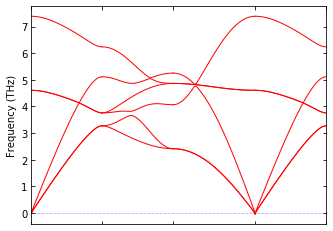

In [9]:

# BAND = 0.0 0.0 0.0  0.5 0.0 0.0  0.5 0.5 0.0  0.0 0.0 0.0  0.5 0.5 0.5
bands = []
append_band(bands, [0.0, 0.0, 0.0], [0.5, 0.0, 0.0])
append_band(bands, [0.5, 0.0, 0.0], [0.5, 0.5, 0.0])
append_band(bands, [0.5, 0.5, 0.0], [0.0, 0.0, 0.0])
append_band(bands, [0.0, 0.0, 0.0], [0.5, 0.5, 0.5])
phonon.set_band_structure(bands)
band_dict = phonon.get_band_structure_dict()
q_points = band_dict['qpoints']
distances = band_dict['distances']
frequencies = band_dict['frequencies']
eigvecs = band_dict['eigenvectors']
# for q_path, d_path, freq_path in zip(q_points, distances, frequencies):
#     for q, d, freq in zip(q_path, d_path, freq_path):
#         print(("%10.5f  %5.2f %5.2f %5.2f " + (" %7.3f" * len(freq)))
#               % ((d, q[0], q[1], q[2]) + tuple(freq)))

phonon.plot_band_structure().show()

In [10]:
# Mesh sampling 20x20x20
phonon.run_mesh(mesh=[20, 20, 20])
phonon.run_thermal_properties(t_step=10,
                              t_max=1000,
                              t_min=0)

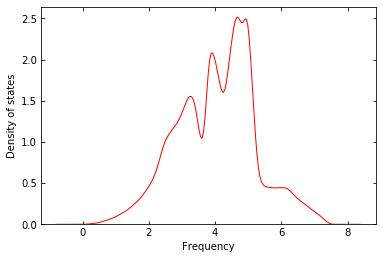

In [13]:
# DOS
phonon.run_total_dos(sigma=0.1)
dos_dict = phonon.get_total_dos_dict()
# for omega, dos in zip(dos_dict['frequency_points'], dos_dict['total_dos']):
#     print("%15.7f%15.7f" % (omega, dos))
phonon.plot_total_dos().show()

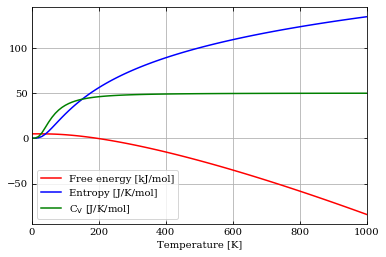

In [15]:
# Thermal properties
tprop_dict = phonon.get_thermal_properties_dict()

# for t, free_energy, entropy, cv in zip(
#         tprop_dict['temperatures'],
#         tprop_dict['free_energy'],
#         tprop_dict['entropy'],
#         tprop_dict['heat_capacity']):
#     print(("%12.3f " + "%15.7f" * 3) % (t, free_energy, entropy, cv))
phonon.plot_thermal_properties().show()

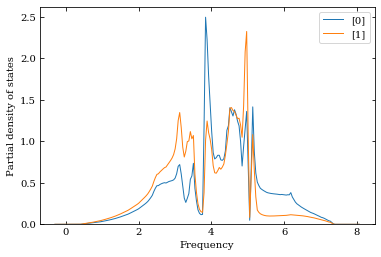

In [16]:
# PDOS
phonon.run_mesh(mesh=[10, 10, 10],
                is_mesh_symmetry=False,
                with_eigenvectors=True)
phonon.run_projected_dos(use_tetrahedron_method=True)
pdos_dict = phonon.get_projected_dos_dict()
omegas = pdos_dict['frequency_points']
pdos = pdos_dict['projected_dos']
pdos_indices = [[0], [1]]
phonon.plot_projected_dos(pdos_indices=pdos_indices,
                          legend=pdos_indices).show()